## Анализ временных рядов

**Загружаю временные ряды**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
passengers = pd.read_csv('data/international-airline-passengers.csv')
passengers.head()

,Month,Count
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
from fbm import FBM
f = FBM(n=144, hurst=0.75)
fbm = f.fbm()

In [5]:
network = pd.read_csv('data/network/Train_data.csv')
network.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [6]:
mean_monthly_temp = pd.read_csv("data/mean-monthly-air-temperature-deg.csv")
mean_monthly_temp.head()

,Month,Mean monthly air temperature (Deg. F) Nottingham Castle 1920-1939
0,1920-01,40.6
1,1920-02,40.8
2,1920-03,44.4
3,1920-04,46.7
4,1920-05,54.1


In [7]:
mean_monthly_temp.rename(columns={'Mean monthly air temperature (Deg. F) Nottingham Castle 1920-1939': 'Deg'}, inplace=True)

In [8]:
#для удобства
all_series = {
    "Passengers" : passengers['Count'],
    "Fractal brownian motion" : pd.Series(fbm),
    "Network count bytes" : network['src_bytes'][2000:],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Random":pd.Series(np.random.randn(250))
}

In [74]:
all_series.keys()

dict_keys(['Passengers', 'Fractal brownian motion', 'Network count bytes', 'Mean monthly air temperature (Deg. F) Nottingham Castle'])

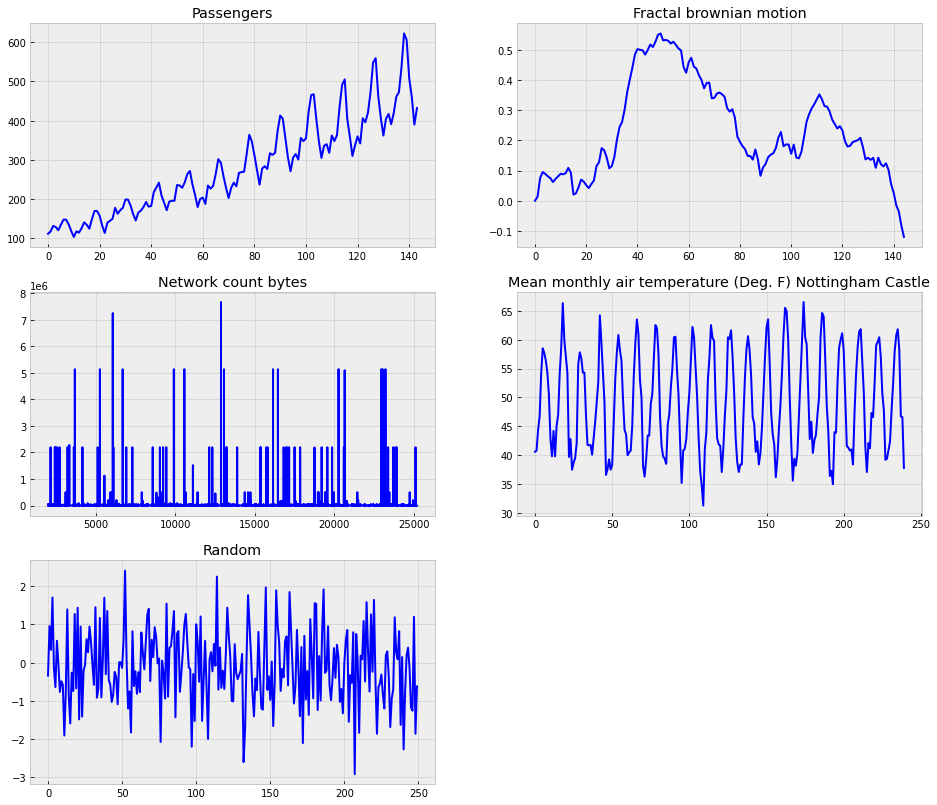

In [9]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 14))
    layout = (3,2)
    
    for val, key in enumerate(all_series.keys()):
        #val 1 2 3 4
        x = val % 2 #0 1 1 0
        y = int((val - x) / 2) #1 1 2 4
        # layout - количество графиков в сетке и  (y,x) - выбор положения графика. 
        ts_ax = plt.subplot2grid(layout, (y,x)) #0:1, 1:1, 1:2 
        all_series[key].plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title(key)

### Скользящее среднее MA

Начнем моделирование с наивного предположения - "завтра будет, как вчера", но вместо просто предсказания вида $\hat{y}_{t} = y_{t-1}$ будем считать, что будущее значение переменной зависит от среднего $n$ её предыдущих значений

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k-1}_{n=0} y_{t-n}$

В данном случае $\hat{y}_{t}$ называется скользящей средней

In [10]:
#rolling - берет выборку из n элементов
test = [1,2,3,4,5,6,7,8]
#суммируем по 3 элементам
pd.Series(test).rolling(3).sum()

0     NaN
1     NaN
2     6.0
3     9.0
4    12.0
5    15.0
6    18.0
7    21.0
dtype: float64

In [11]:
#среднее значение среди 3ех выбранных элементов
pd.Series(test).rolling(3).mean()

0    NaN
1    NaN
2    2.0
3    3.0
4    4.0
5    5.0
6    6.0
7    7.0
dtype: float64

In [12]:
def moving_average(series, n):
    #функция isinstance() для проверки принадлежности данных определенному классу (типу данных)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)  
    return series.rolling(n).mean()

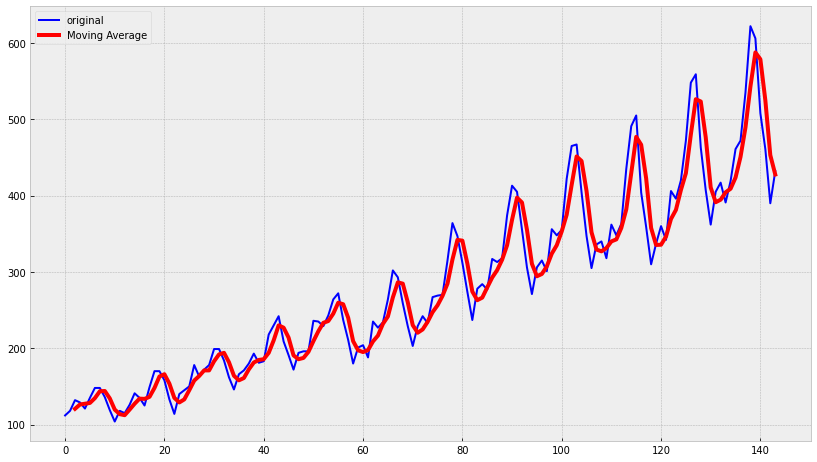

In [13]:
#окно 3
series = moving_average(all_series["Passengers"], 3)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(all_series["Passengers"], color='blue',label='original')
    plt.plot(series, color='red', linewidth='4', label='Moving Average')
    plt.legend()

С окном 3 MA сильно повторяет оригинальный ряд. Построим графики с окном 7 (по 7 предыдущим значениям) для всех рядов.

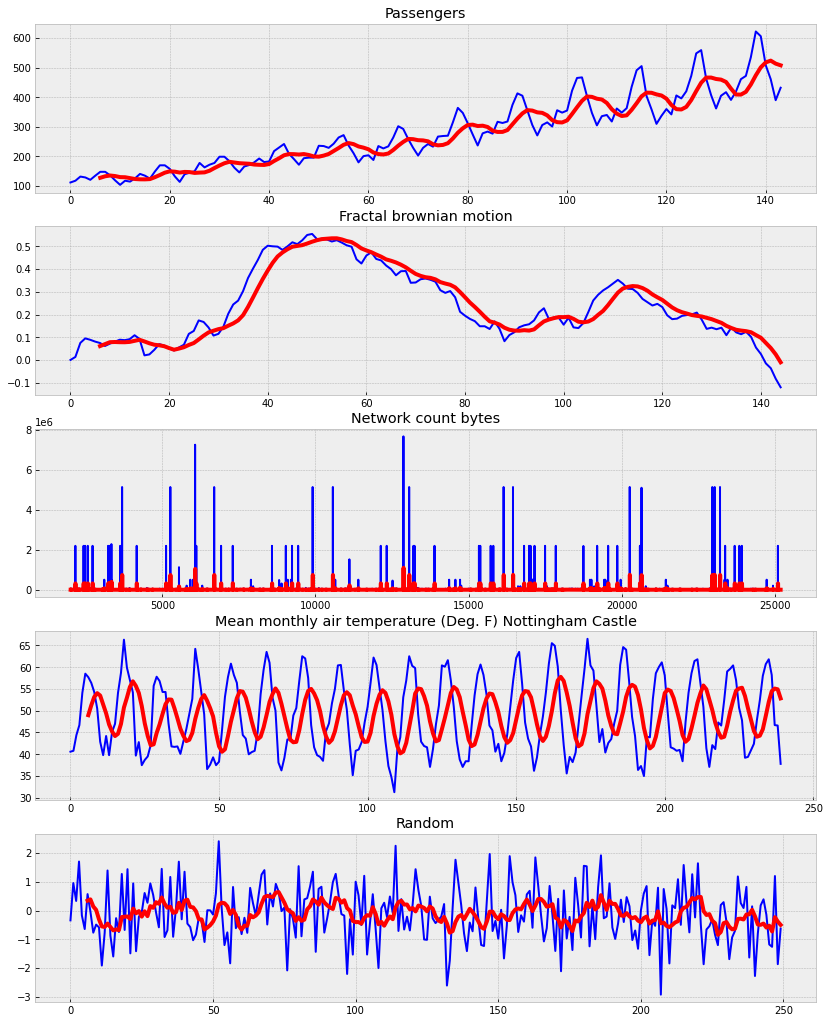

In [14]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 18))
    layout = (5,1)
    series = []
    for val, key in enumerate(all_series.keys()):
        #val 1 2 3 4
        x = 0 
        y = int(val - x)
        # layout - количество графиков в сетке и  (y,x) - выбор положения графика. 
        ts_ax = plt.subplot2grid(layout, (y,x)) 
        
        #скользящее среднее (по 7 предыдущих значений)
        series = moving_average(all_series[key], 7)
        
        all_series[key].plot(ax=ts_ax, color='blue', label='Or')
        plt.plot(series, color='red', linewidth='4', label='Moving Average')

        ts_ax.set_title(key)

В настоящем примере функция MA просто усредняет ряд. Напишим функцию, которая предсказывает следующие измерения.

In [15]:
def predict(series, N, n_pred):
    new_series = series.copy()
    #перебирвем ряд в зависимости от его предсказаний
    for _ in range(n_pred):
        #к существующему ряду добавляем новые значения
        #берем N предыдущих значений и вычисляем среднее
        #средние значения - прогноз
        new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
    return new_series

In [16]:
#скользящее среднее (по 7 предыдущих значений), 50 предсказанных точек 
series_pred = predict(all_series["Passengers"], 7, 50)

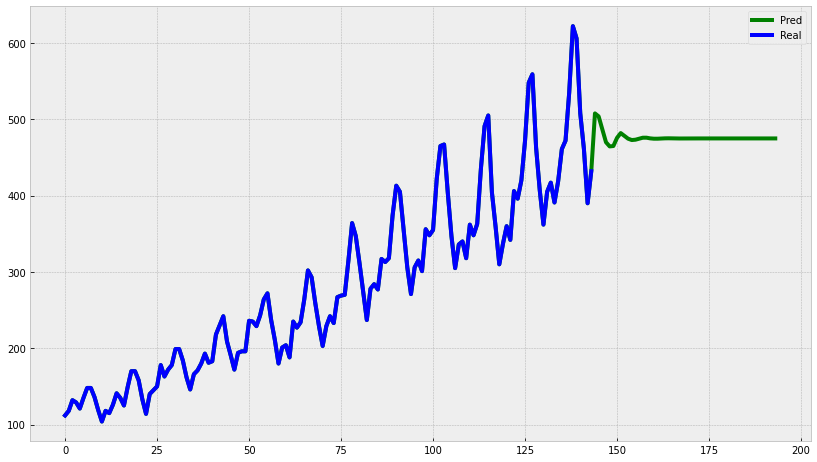

In [17]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred, color='green', linewidth='4', label='Pred')
    plt.plot(all_series["Passengers"], color='blue', linewidth='4', label='Real')
    plt.legend()

Предсказание методом МА не эффективно. Можно прогноизровать только на коротковременные прогнозы. Отобразим прогноз МА на остальных графиках с меньшим количесвтом предсказанных точек.

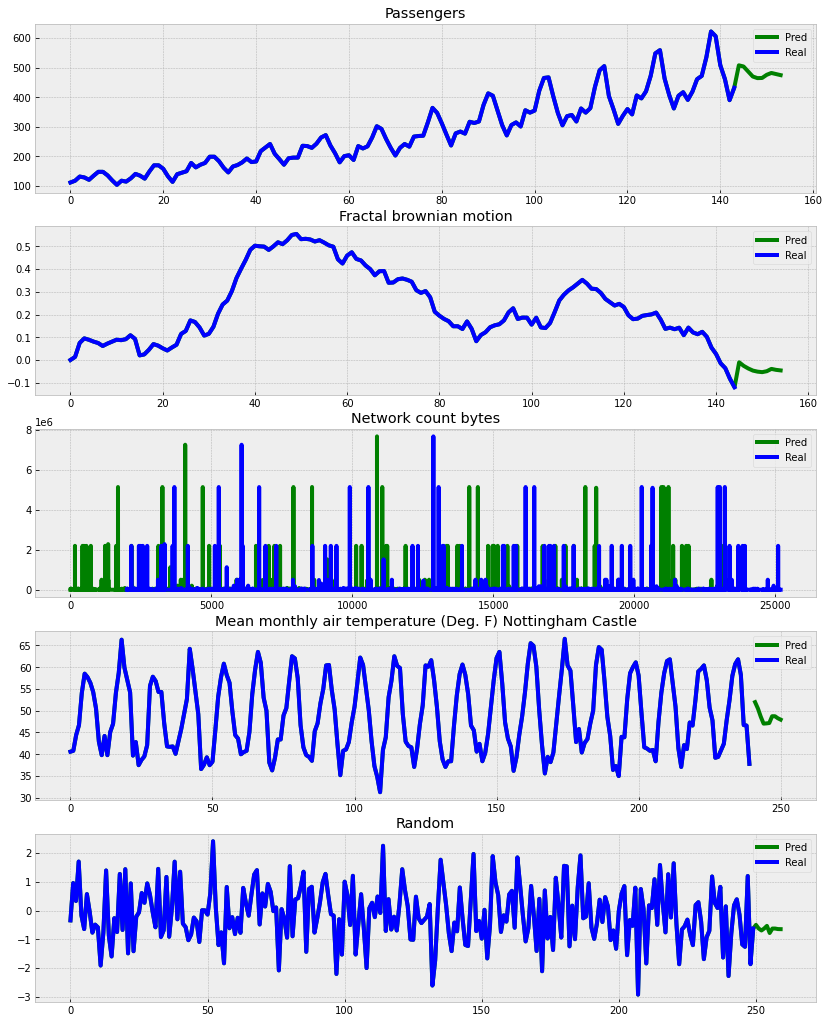

In [19]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 18))
    layout = (5,1)
    series = []
    for val, key in enumerate(all_series.keys()):
        #val 1 2 3 4
        x = 0 
        y = int(val - x)
        # layout - количество графиков в сетке и  (y,x) - выбор положения графика. 
        ts_ax = plt.subplot2grid(layout, (y,x)) 
        
        #скользящее среднее (по 7 предыдущих значений)
        series_pred = predict(all_series[key], 7, 10)
        
        series_pred.plot(color='green', linewidth='4', label='Pred')
        all_series[key].plot(color='blue', linewidth='4', label='Real')
        
        
        ts_ax.set_title(key)
        plt.legend()

МА не может работать с трендом (в долгосрочных прогнозах)

Посомотрим как меняется МА с увеличением размера окна

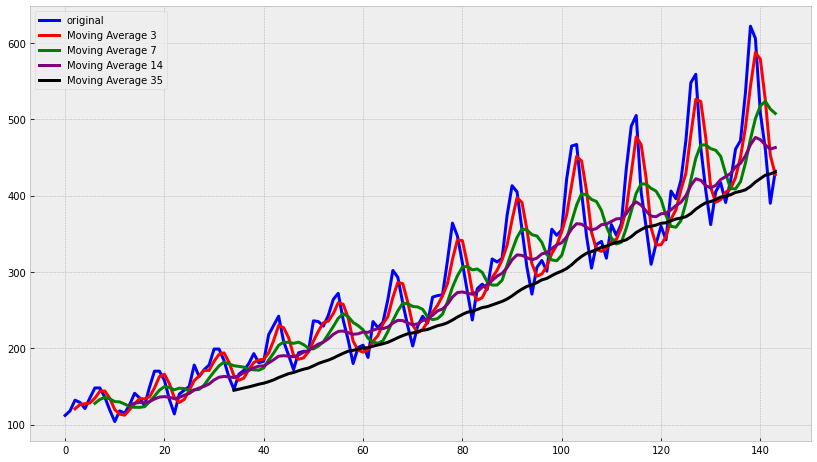

In [20]:
windows = [3,7,14,35]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(all_series["Passengers"], linewidth='3', color='blue',label='original')
    for i in range(len(windows)):
        ser = moving_average(all_series["Passengers"], windows[i])
        plt.plot(ser, color=colors[i], linewidth='3', label='Moving Average {}'.format(windows[i]))
    plt.legend()

Чем больше размер "окна" скользящего среднего $n$ тем более сглаженным получается результат (растягиваем пружину). По нескольким скользящим средним можно увидеть периоды резкого роста и резкого спада.

Характерная особенность обычного скользящего среднего - повышенная чувствительность к выбросам данных

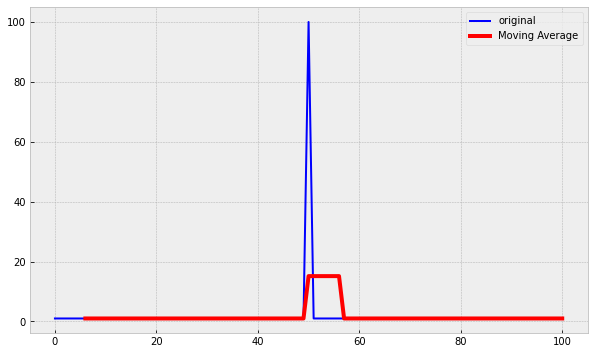

In [21]:
test_time_series = pd.Series([1 for i in range(50)] + [100] + [1 for i in range(50)])
#MA
ser = moving_average(test_time_series, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 6))
    plt.plot(test_time_series, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

In [166]:
test_time_series.unique()

array([  1, 100])

В случае сильно зашумленных данных скользящее среднее помогает определить тренд

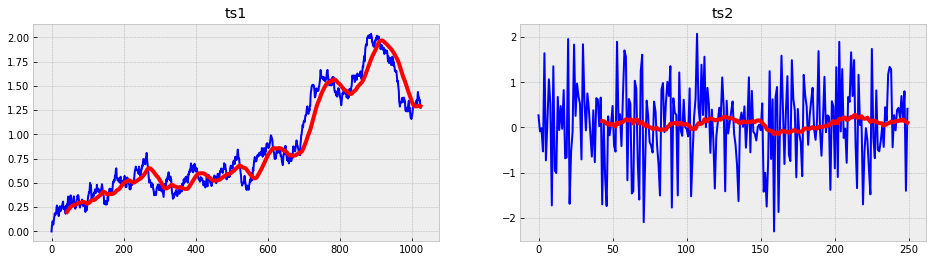

In [22]:
import numpy as np

f = FBM(n=1024, hurst=0.5)
test_time_series_1 = pd.Series(f.fbm())
test_time_series_2 = pd.Series(np.random.randn(250))

dict_test = {
    "ts1":test_time_series_1,
    "ts2":test_time_series_2,
}

with plt.style.context('bmh'):
    plt.figure(figsize=(16, 4))
    layout = (1,2)
    series = []
    for val, key in enumerate(dict_test.keys()):
        x = val % 2
        y = int((val - x)/2)
        ts_ax = plt.subplot2grid(layout, (y,x))
        
        #скользящее среднее (по 7 предыдущих значений)
        series = moving_average(dict_test[key], 44)
        
        dict_test[key].plot(ax=ts_ax, color='blue', label='Or')
        plt.plot(series, color='red', linewidth='4', label='Moving Average')

        ts_ax.set_title(key)


Применения скользящего среднего к случайному шуму с трендом 

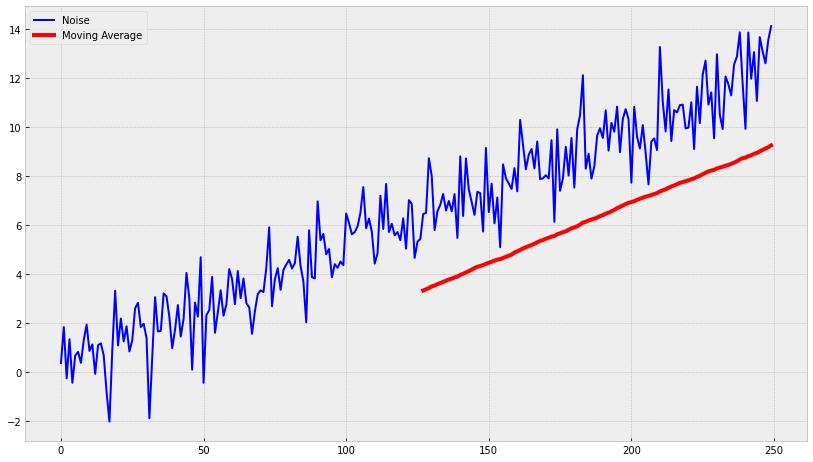

In [23]:
random_noise = np.random.randn(250)
k = 0.05
b = 0
random_noise_trend = pd.Series([k*i + b + random_noise[i] for i in range(len(random_noise))])
ma_on_noise_trend = moving_average(random_noise_trend, 128)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(random_noise_trend, color='blue',label='Noise')
    plt.plot(ma_on_noise_trend, color='red', linewidth='4', label='Moving Average')
    plt.legend()

### Взвешенное скользящее среднее WMA

Модификацией обычной скользящей средней является взвешенная скользящая средняя. Каждое предыдущее значение имеет не одинаковый вес, а мы можем указать на сколько важно наше историческое значение для нового прогноза.

$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$

$\displaystyle\sum^{k}_{n=1} {\omega_n} = 1$

Обычно чем ближе измерение к прогнозируемому - тем больше его вес.

In [24]:
def weighted_moving_average(series, n, weights):
    
    #функция isinstance() для проверки принадлежности данных определенному классу (типу данных)
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    
    #n - размер окна, его лучше определять как кол-во весов n=weights.shape[0] (чтоб не ошибиться)
    n=weights.shape[0]
    
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

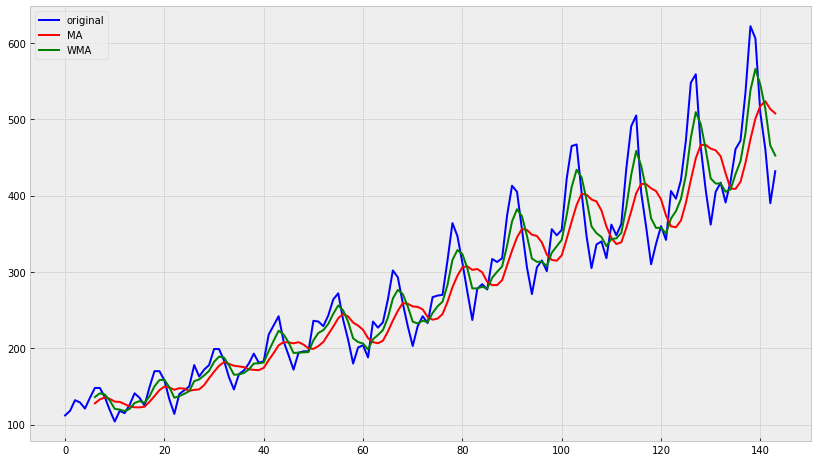

In [25]:
wma = weighted_moving_average(all_series["Passengers"], 7, [1,1,2,3,5,8,13]) #числа Фибоначчи (Обычно чем ближе измерение к прогнозируемому - тем больше его вес)
ma = moving_average(all_series["Passengers"], 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(all_series["Passengers"], color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

Такая вариация moving average позволяет учитывать временной контекст. Чем раньше было событие - тем меньше оно влияет на прогнозируемое событие. Сдвиг стал меньше. Более чувствителен к колебаниям.

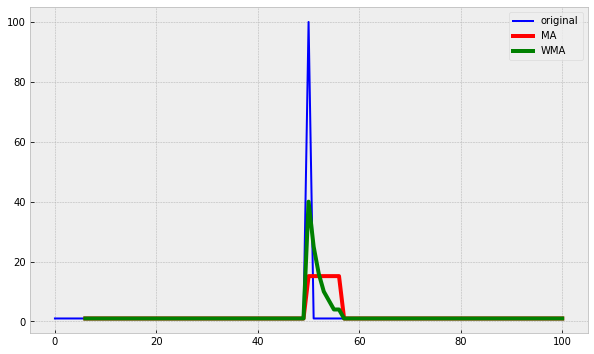

In [26]:
ts = pd.Series([1 for i in range(50)] + [100] + [1 for i in range(50)])
ma = moving_average(ts, 7)
wma = weighted_moving_average(ts, 7, [1,1,2,3,5,8,13])
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 6))
    plt.plot(ts, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='4', label='MA')
    plt.plot(wma, color='green', linewidth='4', label='WMA')
    plt.legend()

WMA раньше реагирует на всплекс, но также и затухает раньше чем MA. WMA и MA сходятся в одном и том же месте.

Посмотрим как выглядит WMA при разных весах

In [27]:
series = all_series["Passengers"][60:100]
wma_fib = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])
wma_seq = weighted_moving_average(series, 7, [1,2,3,4,5,6,7])
wma_pow = weighted_moving_average(series, 7, [1,2,4,8,16,32,64])

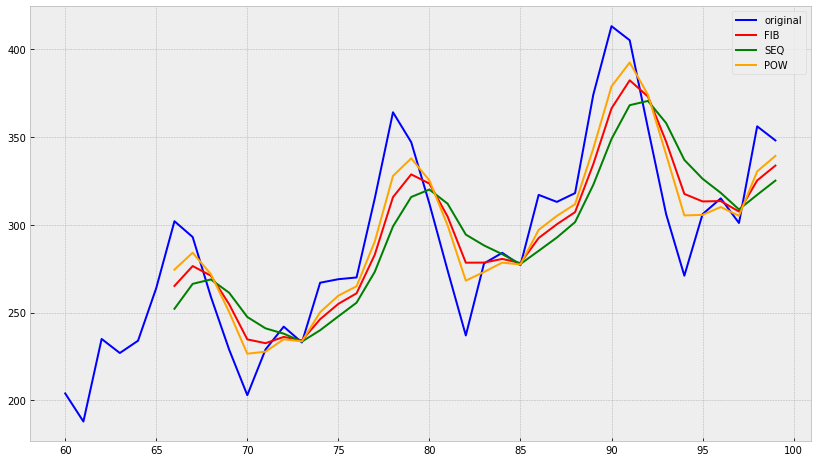

In [28]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    
    plt.plot(wma_fib, color='red', linewidth='2', label='FIB')
    plt.plot(wma_seq, color='green', linewidth='2', label='SEQ')
    plt.plot(wma_pow, color='orange', linewidth='2', label='POW')
    plt.legend()

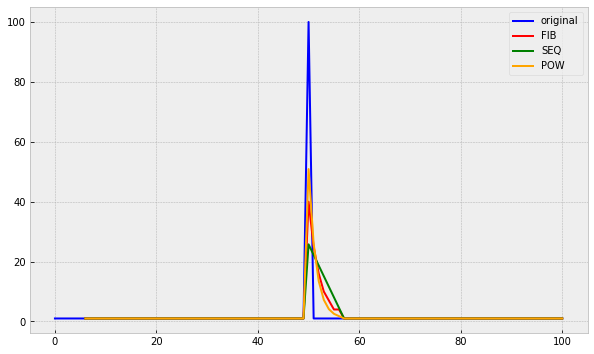

In [29]:
ts = pd.Series([1 for i in range(50)] + [100] + [1 for i in range(50)])
wma_fib = weighted_moving_average(ts, 7, [1,1,2,3,5,8,13])
wma_seq = weighted_moving_average(ts, 7, [1,2,3,4,5,6,7])
wma_pow = weighted_moving_average(ts, 7, [1,2,4,8,16,32,64])
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 6))
    plt.plot(ts, color='blue',label='original')
    plt.plot(wma_fib, color='red', linewidth='2', label='FIB')
    plt.plot(wma_seq, color='green', linewidth='2', label='SEQ')
    plt.plot(wma_pow, color='orange', linewidth='2', label='POW')
    plt.legend()

Чем ближе описывает временной ряд, тем больше подается всплескам

 ## Экспоненциальное сглаживание (EMA)

Мы хотим учитывать не какой-то фиксированный набор измерений. В идеале - мы хотим учитывать всю историю измерений, накопившуюся к текущему моменту. Просто, как и в случае WMA, чем дальше измерение - тем меньше вклад. Для этого используется экспоненциальное скользящее среднее:

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

В нем предсказанное значение - это взвешеное срденее между последним наблюдением и предыдущей историей. Легко заметить, что формула рекурсивна. Параметр $\alpha$ называется сглаживающим фактором. Он определяет, как сильно мы будем опираться на историю (чем меньше - тем больше). Чем меньше $\alpha$, тем больше влияния оказывают предыдущие предсказанные значения, и тем сильнее сглаживается ряд. 

In [30]:
#чем больше alpha, тем больше во внимание берем предыдущие значения
def exponential_moving_average(series, alpha):
    result = [series[0]]#курсор на 1ое знаечние
   
    for n in range(1, len(series)):#перебор со второго
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])

    return pd.Series(result)

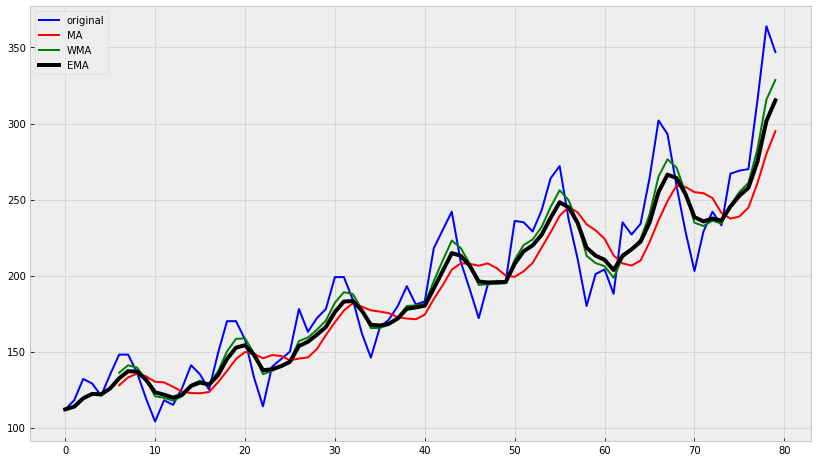

In [31]:
series = all_series["Passengers"][0:80]


ema = exponential_moving_average(series, 0.3)
wma = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])
ma = moving_average(series, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

Получили усредненную оценку...Что-то среднее между MA и WMA.

Посмотрим на различных значениях alpha

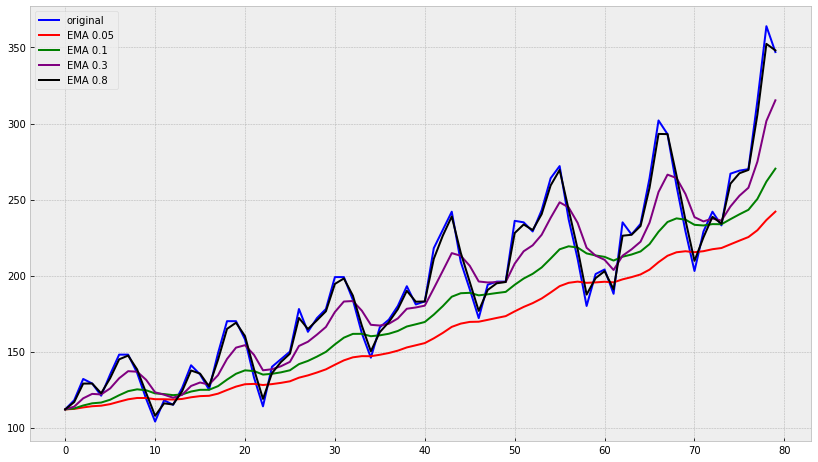

In [32]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    for i in range(len(alphas)):
        ser = exponential_moving_average(series, alphas[i])
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.legend()

Чем больше alpha тем больше EMA смотрит на предыдущие значения. Напишим функцию, которая предсказывает следующие измерения.

In [33]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    #предсказание по последниму значению датасета 
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    #предсказание по последниму значению предсказания
    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)

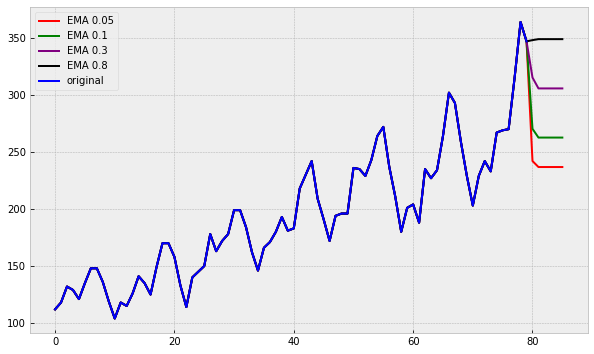

In [34]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 6))
    for i in range(len(alphas)):
        ser, _ = exponential_moving_average(series, alphas[i], 5)
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.plot(series, color='blue',label='original')
    plt.legend()

Не удается предсказать новые значения из-за наличия тренда (временных характеристик). Поэтому было разработано двойное экспоненциальное сглаживание, которое учитывает тренд.

## Двойное экспоненциальное сглаживание (DEMA)

$$\hat{y}_t=l_t + s_t$$
$$\hat{y}_t=\alpha y_t + (1-\alpha)\hat{y}_{t-1}$$
$$\hat{l}_t = \alpha y_t + (1-\alpha)(l_{t-1} + s_{t-1})$$

До сих пор мы рассматривали ряд - как единую составляющую. Но на самом деле, ряд $y_t$ можно представить в виде суммы $l_t$ (уровня) и $s_t$ (тренда). По сути - тренд - это основное направление движения ряда, а уровень - колебание вокруг этого тренда.

Для предсказания уровня мы используем подход на основе классического EMA:

$l_t = \alpha y_t + (1-\alpha)(l_{t-1} + s_{t-1})$

Для прогноза тренда используем так же EMA и простое соображение: историческое значение тренда - это историческое значение тренда, а текущее значение тренда - это изменение уровня. Получим такую формулу:

$s_t = \beta (l_t - l_{t-1}) + (1 - \beta) s_{t-1}$

Итоговый ряд предсказываем по следующей формуле

$\hat{y}_{t+1} = l_t + s_t$

In [35]:
##чем больше alpha, тем больше во внимание берем предыдущие значения
#beta-регулирует, как сильно предыдущие значения будут влиять для составления тренда
def double_ema(series, alpha, beta):
    #берем первое значение из временного ряда (историческое)
    result = [series[0]]
    #series[1] - series[0] - трендовая составляющая (тренд, определяет куда мы движемся)
    #series[0] - не зависит от тренда
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        #текущее состояние
        value = series[n]
        #last_level=level - уровень на предыдущем шаге
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [36]:
def plot_dema(alpha, beta):
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(10, 6))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

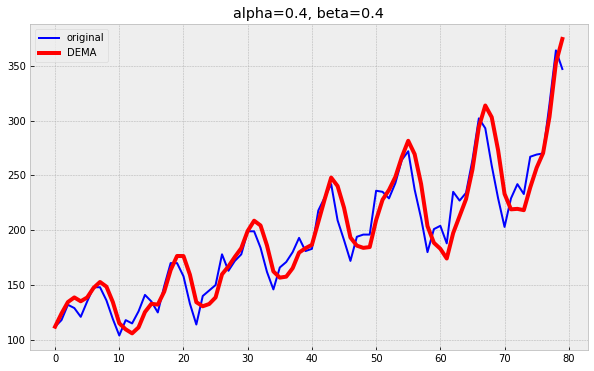

In [40]:
#alpha - Фактор сглаживания для уровня.
#beta -  Сглаживающий фактор для тренда.
plot_dema(0.4, 0.4)

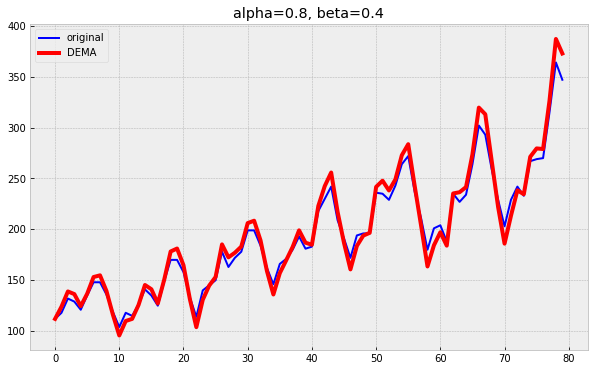

In [50]:
plot_dema(0.8, 0.4)

Если делаем большой акцент на предыдущее значение (alpha-Фактор сглаживания для уровня)  и учитываем, что предыдущее значение тренда важнее чем текущее знаечние тренда (beta-Сглаживающий фактор для тренда != 0), то получаем хорошее описание функции.

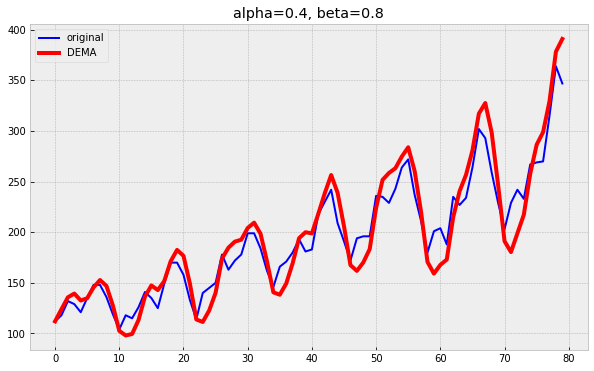

In [48]:
plot_dema(0.4, 0.8)

Если сделаем наоборот, то из-за того, что делаем большой акцент на сглаживающий фактор для тренда - имеем сдвиг. Запаздалая реакция.

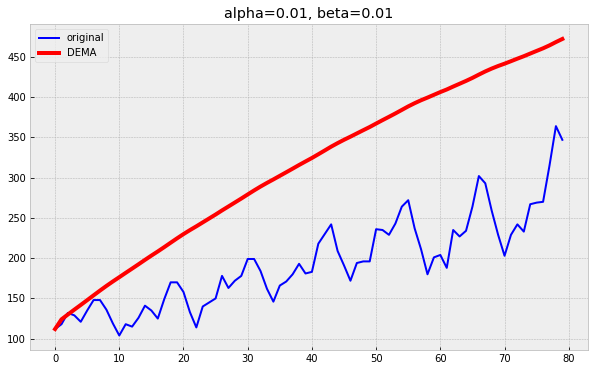

In [54]:
plot_dema(0.01, 0.01)

Если не учитваем alpha и beta, то график сразу начинает падать, т.к не устаканлся (не сформировал устойчивые значения)

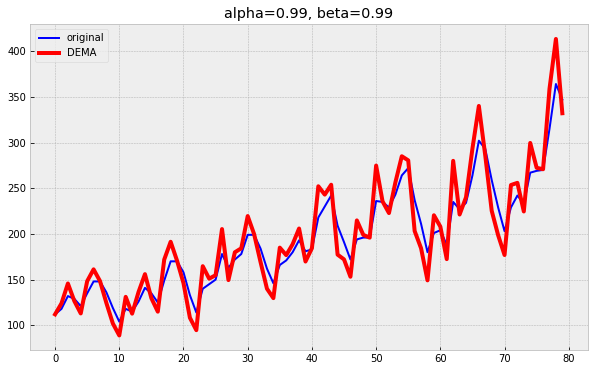

In [52]:
plot_dema(0.99, 0.99)

Из-за большого alpha и beta возникает преобучение (грубое описание)

Как мы видим, настройка параметров $\alpha$ и $\beta$ может порой давать самые причудливые результаты. $\alpha$ отвечает за сглаживание ряда вокруг тренда, $\beta$ - за сглаживание самого тренда. Чем больше значения, тем более значимыми будут последние наблюдения и менее значимой будет история.

Напишим функцию, которая предсказывает следующие измерения.

In [55]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        #в кач-ве предсказания использую последнее значение result и аналогично
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)

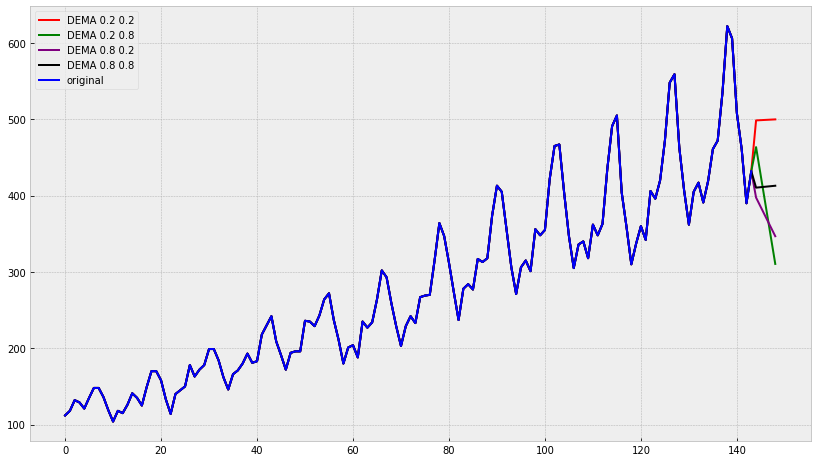

In [57]:
alphas = [0.2,0.2,0.8,0.8]
bettas = [0.2,0.8,0.2,0.8]
colors = ['red', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = double_ema_with_preds(all_series["Passengers"], alphas[i], bettas[i], 5)
        plt.plot(ser, color=colors[i], linewidth='2', label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.plot(all_series["Passengers"], color='blue',label='original')
    plt.legend()

Чтобы хорошо спрогнозировать график мы не учли сезонность

## Тройное экспоненциальное сглаживание - Хольт-Винтерс (TEMA) 

Суть метода в том, что начинаем еще учитывать сезонность. Она учитывается в виде третьей компоненты.

**Важно** - метод применим только в случае сезонности. Если ее нет - метод хольта-винтерса не даст хороших результатов;

$l_t = \alpha(y_t - p_{t-\tau}) + (1-\alpha)(l_{t-1} + s_{t-1})$


$s_t = \beta(l_t - l_{t-1}) + (1-\beta)s_{t-1}$

$p_t = \gamma(y_t - l_t) + (1-\gamma)p_{t-\tau}$

$\hat{y}_{t+m} = l_x + s_t + p_{t-\tau+1+(m-1)mod\tau}$

Сезонная компонента $p_t$ объясняет повторяющиеся колебания вокруг уровня и тренда; ее параметр - период, после которого начинаются повторения колебаний. Для каждого наблюдения в сезоне формируется своя компонента, например, если длина сезона составляет 3, то мы получим 3 сезонные компоненты.

В уровене из значения ряда теперь вычитается сезонная компонента;

Тренд остаётся без изменений;

Сезонная компонента зависит от текущего значения ряда за вычетом уровня и от предыдущего значения компоненты.

**При сглаживании сезонной компоненты - она сглаживается только со своими измерениями**

In [58]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [59]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)#кол-во сезонов
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))#сезонные компаненты
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons#усредняем значения за все сезоны
    return seasonals

In [60]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    #получаем сезонные компаненты
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        #если это значение первое (мы еще ничего не делали)
        if i == 0: # initial values
            smooth = series[0]#получаем сглаживание
            trend = initial_trend(series, slen)#записываем трендовую компоненту 
            result.append(series[0])#добавляем 1-ое значение результата
            continue
        #прогноз
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            #получаем текущее значение временного ряда
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            #сумма 3-ех компонент: сезонность, тренд, уровнь
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [63]:
def plot_tema(alpha, beta, gamma, ser=all_series["Passengers"], ser_to_plot=all_series["Passengers"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

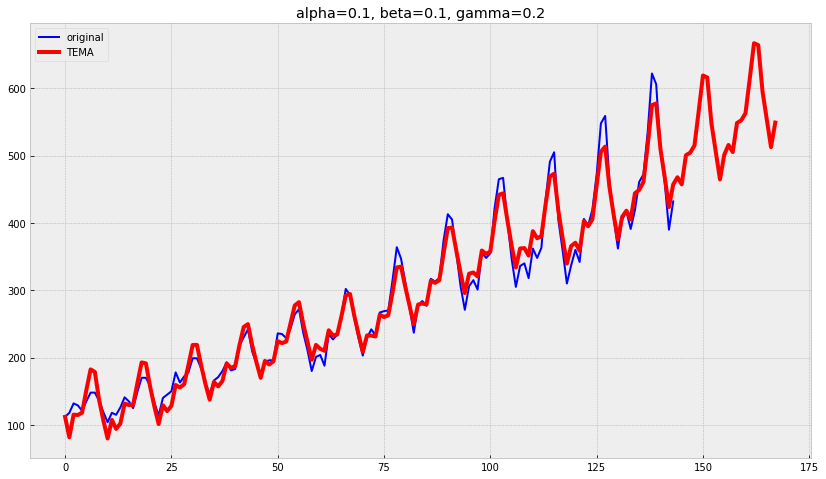

In [64]:
plot_tema(0.1, 0.1, 0.2)

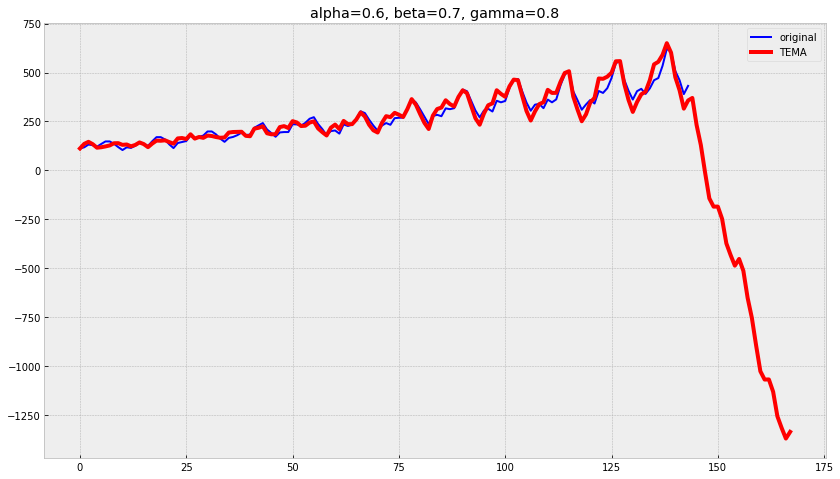

In [65]:
plot_tema(0.6, 0.7, 0.8)

Если учитывает только последние значения, на предыдущие значения внимания маеньше обращать то отображает только скочки

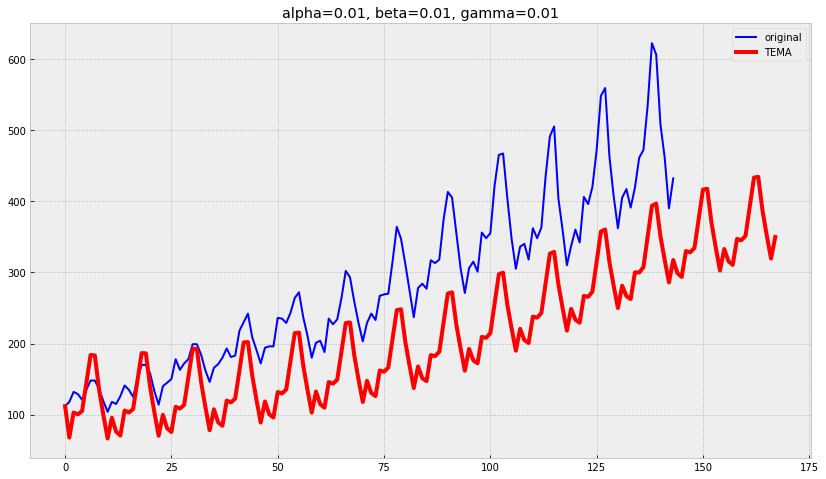

In [66]:
plot_tema(0.01, 0.01, 0.01)

При занижении значений проседает

## Подбор параметров

Что значит, что наша модель лучше всего приближает исходные данные? Это значит, что минимизируется некоторая функция ошибки. Мы, для простоты, будет считать стандарнтый RMSE:

$RMSE =  \sqrt {1/n \sum^N_{i=1} (\hat{y}_i - y_i)^2}$

Алгоритм поиска стандартный - метод градиентного спуска. Считаем производный по каждому из параметров и спускаемся в сторону минимума.

In [210]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [275]:
series = all_series["Passengers"]

In [276]:
train, test, val = series[:60], series[60:70], series[70:]

In [277]:
#определяем ошибку
def mse(X):#alpha, beta, gamma
    alpha, beta, gamma = X
    #12 - размер сезонности, train - обучаемая часть, (lpha, beta, gamma) - их хотим найти,прогноз на len(test) 
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)#сравниваем то что предскзаали с истиными значениями
    return error

In [278]:
#x0 с чего начинаем подбор, method оптимизатор, bounds - границы (значения от 0 до 1)
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
alpha_opt, beta_opt, gamma_opt = opt.x #получаем значения х
print(opt)

      fun: 175.55253454606682
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([15.13668906,  0.03071818, 10.57188115])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 856
      nit: 136
     njev: 214
   status: 0
  success: True
        x: array([0.00267846, 0.87575616, 0.        ])


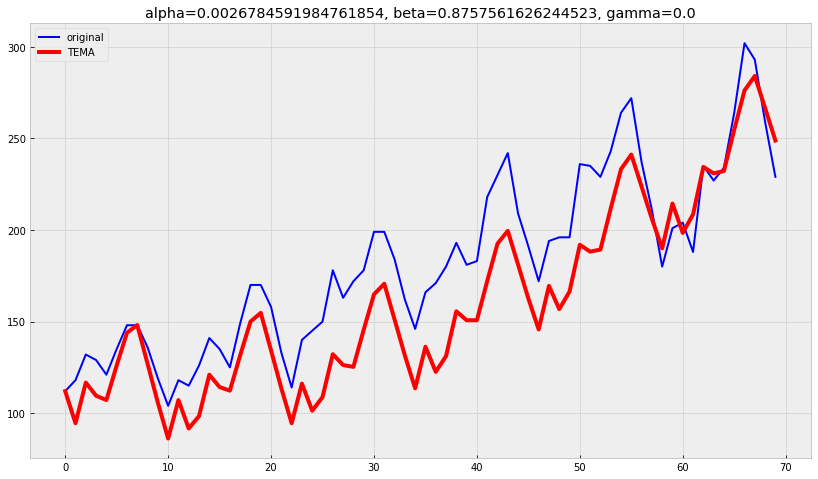

In [279]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:70], n_preds=len(test))

Как и для прочих экспоненциальных сглаживаний, alpha, beta и gamma подбираются методом проб и ошибок таким образом, чтобы минимизировать среднеквадратическую ошибку.

Если взять обучаемую и тестовую часть и добавить часть которая вообще не участвовала в обучении (формировании alpha, beta и gamma) - len(val):

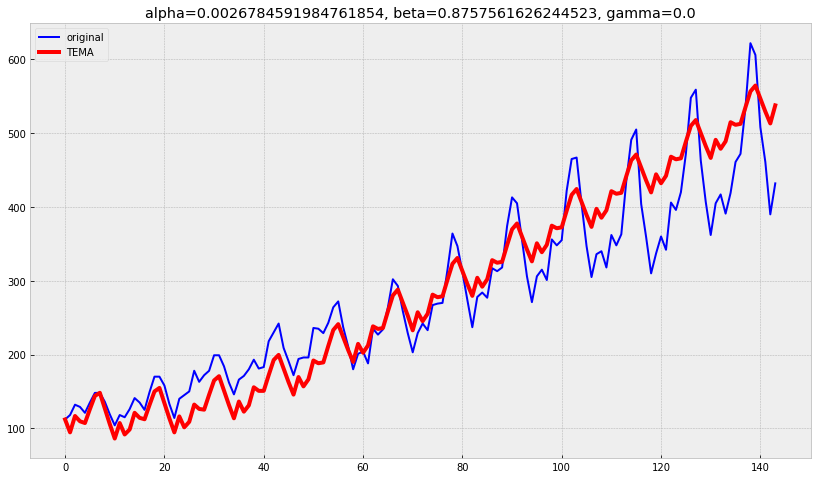

In [280]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:70], ser_to_plot=series, n_preds=len(val))

По графику можно сделать вывод о недостке параметра отвевчающего за тренд

In [281]:
all_series_2 = {
    "Passengers" : passengers['Count'],
    "Fractal brownian motion" : pd.Series(fbm),
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Random":pd.Series(np.random.randn(250))
}

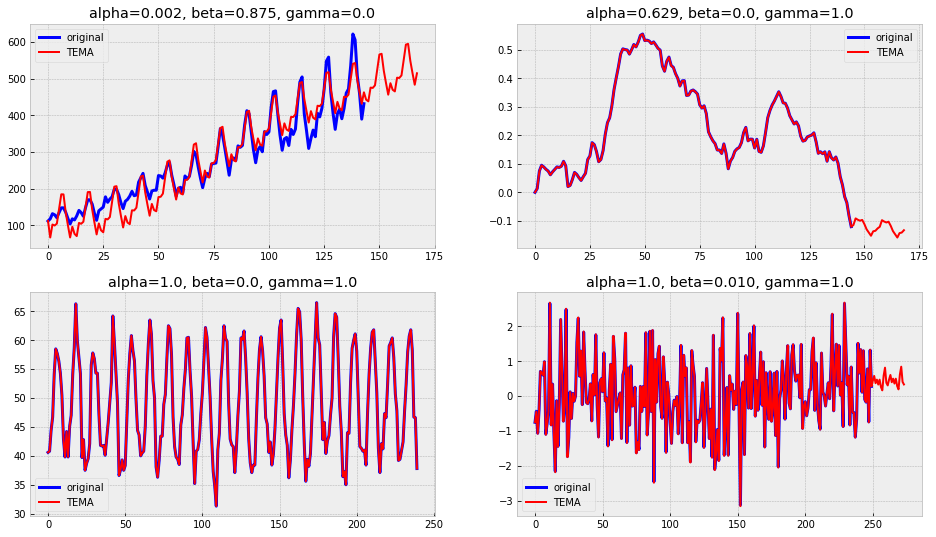

In [284]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 14))
    layout = (3,2)
    
    for val, key in enumerate(all_series_2.keys()):
        #val 1 2 3 4
        x = val % 2 #0 1 1 0
        y = int((val - x) / 2) #1 1 2 4

        ts_ax = plt.subplot2grid(layout, (y,x)) #0:1, 1:1, 1:2 
        
        
        train, test, val = all_series_2[key][:60], all_series_2[key][60:70], all_series_2[key][70:]
        opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
        alpha_opt, beta_opt, gamma_opt = opt.x #получаем значения х

        tema = triple_exponential_smoothing(all_series_2[key], 12, alpha_opt, beta_opt, gamma_opt, n_preds=24)
        
        plt.plot(all_series_2[key], linewidth='3', color='blue',label='original')
        plt.plot(tema, color='red', linewidth='2', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(str(alpha_opt)[:5], str(beta_opt)[:5], str(gamma_opt)[:5]))
        plt.legend()


## Кросс-валидация

Проблема кросс-валидации на временных рядах состоит в том, что случайно перемешивать в фолдах значения всего ряда нельзя. Т.к. он имеет временную структуру, и ее надо сохранять (иначе потеряются все взаимосвязи наблюдений);

Будем делать кросс-валидацию на скользящем окне.

Суть достаточно проста:
1. Берем t измерений
2. Делаем прогноз на n измерений вперед и считаем ошибку
3. Берем t+n измерений
4. Делаем прогноз на n измерений вперед и считаем ошибку
5. Берем t+2*n измерений
6. Делаем прогноз на n измерений вперед и считаем ошибку
...

In [327]:
series = all_series["Passengers"]
train, val = series[:65], series[65:]

In [323]:
from sklearn.model_selection import TimeSeriesSplit#делит временной ряд на определенные куски

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3)#данные делим на 3 разделения
    errors = []
    
    for train_split, test_split in split.split(train):#прогоняем 3 раза
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]

        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)#среднее от ошибок
        errors.append(error)
        print(f'error: {np.mean(np.array(errors))}')
    return np.mean(np.array(errors))

In [331]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

error: 2295.4539930555493
error: 4398.253472222207
error: 7159.498263888861
error: 2295.4537556389096
error: 4398.252566936865
error: 7159.495974900165
error: 2295.4539930555493
error: 4398.253472222207
error: 7159.498263888861
error: 2295.4539740476366
error: 4398.253401991598
error: 7159.498077769008
error: 969.4539930555549
error: 838.5295138888885
error: 635.860677083333
error: 969.4539913150292
error: 838.5295107193849
error: 635.860678962783
error: 969.4538874480722
error: 838.5293232051503
error: 635.860513160492
error: 969.4539930555549
error: 838.5295138888885
error: 635.860677083333
error: 710.0082828235741
error: 454.1307219765205
error: 525.6004617704801
error: 710.0082792838714
error: 454.13071838159397
error: 525.6004427767898
error: 710.0082861264293
error: 454.13072307016705
error: 525.6004816472085
error: 710.0082828235741
error: 454.1307219765205
error: 525.6004617704801
error: 707.2851427002013
error: 453.04181782216165
error: 502.7648299294771
error: 707.28514605659

error: 228.1394417217437
error: 149.13303987792884
error: 218.49426175406225
error: 228.1394454282849
error: 149.1330314075693
error: 218.49426620419612
error: 228.13945074430865
error: 149.13303278307131
error: 218.4942678969331
error: 617.1563482338502
error: 603.3119936643825
error: 494.3818399447403
error: 617.1564862783678
error: 603.3120552791037
error: 494.3818812123827
error: 617.1563704616391
error: 603.3120090817115
error: 494.38185040617526
error: 617.156357120931
error: 603.3119969753777
error: 494.3818411190832
error: 219.39371516134975
error: 149.97153537030465
error: 215.60601429611427
error: 219.39372097355016
error: 149.97155209107376
error: 215.60601451998514
error: 219.3937126455807
error: 149.97153566641015
error: 215.6060132158353
error: 219.39371678428202
error: 149.97153623114883
error: 215.60601449123214
error: 125.0028598480542
error: 132.679595976643
error: 186.2458043501389
error: 125.00287875182832
error: 132.67962535404308
error: 186.24580915553443
error: 1

Видим, как уменьшалась ошибка

In [332]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 174.68168645457283
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.26894076e-03, -1.74288771e+01, -1.01749720e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 204
      nit: 35
     njev: 51
   status: 0
  success: True
        x: array([0.02393  , 1.       , 0.0385583])


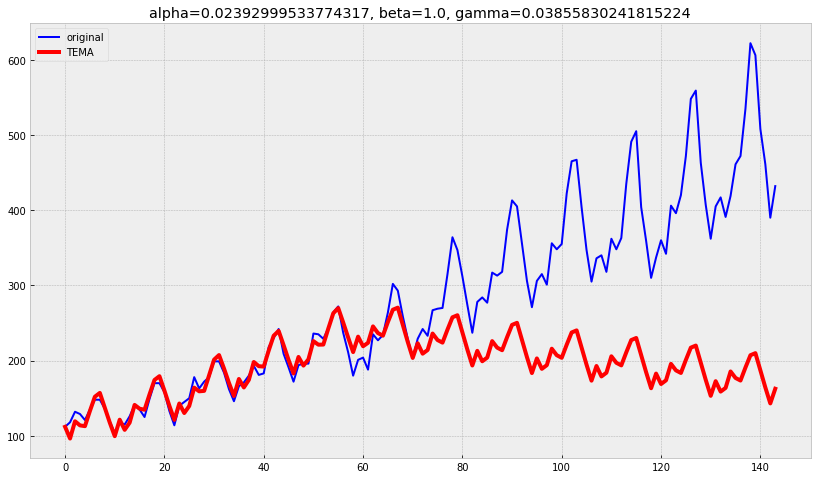

In [333]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

Из графика можно сделать вывод об убывании тренда. Зададим параметр beta вручную.

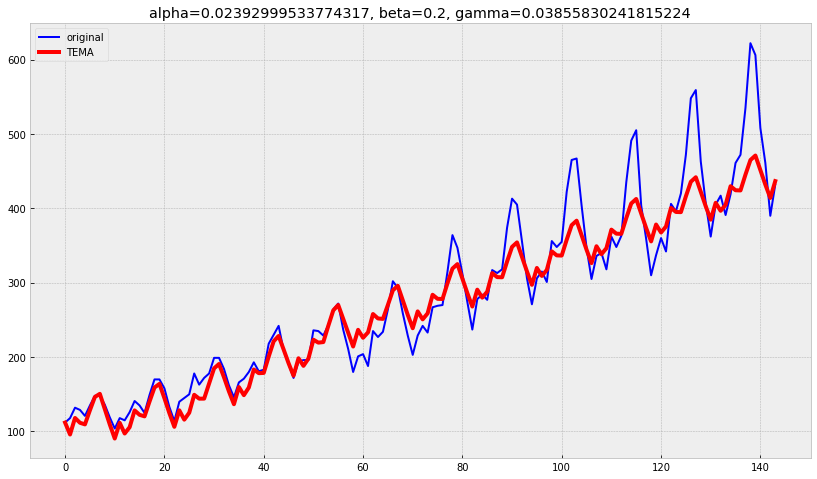

In [334]:
plot_tema(alpha_opt, 0.2, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

error: 0.017390940967068915
error: 0.12133996227103266
error: 0.17221150841469926
error: 0.01739093808719066
error: 0.12133994635788471
error: 0.17221146121359912
error: 0.017390940967068915
error: 0.12133996227103266
error: 0.17221150841469926
error: 0.01739094071243658
error: 0.12133996100411318
error: 0.17221150456334666
error: 0.014721551500464218
error: 0.04139017470687888
error: 0.032483809378098555
error: 0.014721551520688339
error: 0.041390174837674515
error: 0.03248380926395478
error: 0.0147215512377125
error: 0.04139016908863451
error: 0.03248381025917711
error: 0.014721551500464218
error: 0.04139017470687888
error: 0.032483809378098555
error: 0.014726211292908024
error: 0.04142101211679891
error: 0.032457200026791845
error: 0.014726211273593613
error: 0.04142101198594071
error: 0.03245720013868415
error: 0.014726211030721999
error: 0.04142100649931113
error: 0.03245720088129842
error: 0.014726211292892321
error: 0.041421012116662805
error: 0.03245720002604222
error: 0.014742

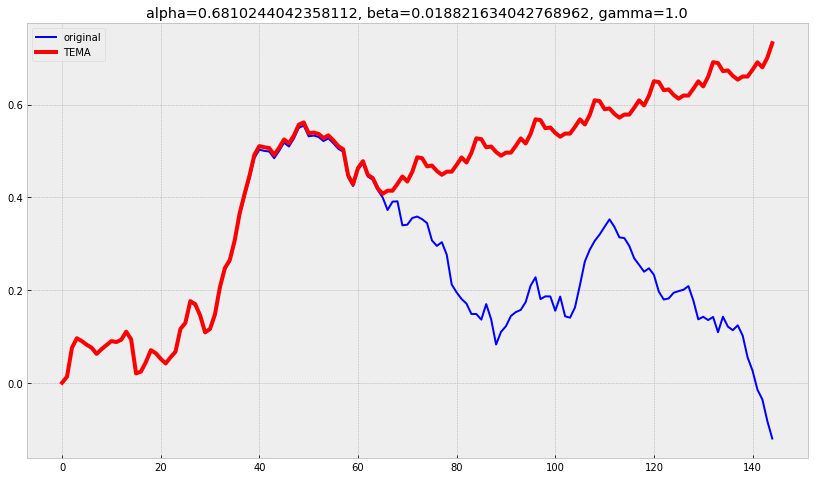

In [335]:
series = pd.Series(fbm)
train, val = series[:65], series[65:]
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
alpha_opt, beta_opt, gamma_opt = opt.x
